# **DeePTB** 快速上手指南 | 训练 Silicon 的紧束缚模型模型

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Authors</i></b><br/>
        作者: <a style="font-weight:normal" href="mailto:guqq@pku.edu.cn">顾强强 📨 </a>, <a href="mailto:zhouyinzhanghao@gmail.com">周寅张皓 📨 </a>, <a href="mailto:ganzixi@dp.tech">甘子熙 📨 </a></b></i><br/>
        日期：2024-01<br/>
        共享协议：本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i><br/>
        快速开始：点击上方的 <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">开始连接</span> 按钮，稍等片刻即可运行。
    </p>
</div>

<p style="color:purple; font-weight:bold">DeePTB是使用深度学习构建第一性原理精度的紧束缚（TB）模型的方法，可用于加速材料的电子结构计算。本教程主要介绍DeePTB的基本操作，涉及数据的准备、模型训练以及调用。</p>

完成本案例你将：
1. 熟悉 DeePTB 模型的训练流程
2. 得到高精度的硅晶体的完整 DeePTB 模型
3. 熟悉 DeePTB 性质计算模块的使用方式

## 目录

* [方法介绍](#method)
* [方法实践](#practice)
  * [1. 数据准备](#dataprepare)
  * [2. 训练模型](#train)
  * [3. 性质计算](#application)

## 方法介绍: <a id ='method'></a>
**DeePTB** 方法的基本思想是通过深度学习DFT电子能带，从而构建紧束缚（Tight-Binding, TB）模型，从而快速实现第一性原理精度的电子结构和性质计算。 
在 TB 模型中，哈密顿矩阵元可以表示为:
$
\begin{equation}
H_{i,j}^{lm,l^\prime m^\prime} =  \left\langle {i,lm} \right| \hat{H} \left| {j, l^\prime m^\prime} \right\rangle 
\end{equation}
$
其中 $i$, $j$ 是原子的 site 指标。$l$ 和 $m$ 是 site 对应原子的轨道角量子数与磁量子数（angular and magnetic quantum number）。**DeePTB** 的方法的目标就是通过学习DFT的电子能量本征值，利用神经网络预测给定结构的哈密顿量矩阵元。但是，由于哈密顿量本身具有规范变化自由度，因此电子能量本征值并不能完全决定哈密顿量。因此在 **DeePTB** 中选取了传统的 Slater-Koster (SK) 参数化的哈密顿量，即：所有的哈密顿量跃迁矩阵元可以从规范无关的参数SK键积分 $h_{ss\sigma}, h_{sp\sigma}, h_{pp\sigma}, h_{pp\pi}, \cdots$ 等来表示。根据这些键积分，我们可以构建旋转变换到哈密顿量矩阵元，即:
$
\begin{equation}
	H_{i,j}^{lm,l^\prime m^\prime} = \sum_{\zeta} \Big[ \mathcal{U}_{\zeta}(\hat{r}_{ij}) \ h_{ll^\prime \zeta} \Big]_{mm^\prime}
\end{equation}
$
这里 $\mathcal{U}_{\zeta}$ 是一个 $[2l+1,2l^\prime+1]$ 的旋转矩阵，$\zeta$ 表示成键类型如：$\sigma, \pi$等。$\mathcal{U}_{\zeta}$的具体形式可以参考[Ref:1](https://journals.aps.org/pr/abstract/10.1103/PhysRev.94.1498)

传统的 SK-TB 中，SK 键积分往往采用了经验规则下的解析表达式，键积分基于双中心近似并只和两个原子的距离有关。 在 **DeePTB** 中，我们采用了一种基于神经网络的方法来预测 SK 键积分，即:
$
\begin{equation}
h^{\text{env}}_{ll^\prime{\zeta}} =  h_{ll^\prime{\zeta}}(r_{ij}) \times \left[1+\Phi_{ll^\prime\zeta}^{o_i,o_j}\left(r_{ij},\mathcal{D}^{ij}\right)\right]	
\end{equation}
$

其中 $h_{ll^\prime{\zeta}}$ 同样是基于解析表达式且只两个原子的距离有关的SK键积分，在DeePTB 中解析表达式的待定系数由trainable神经元表示。而 $h^{\text{env}}_{ll^\prime{\zeta}}$ 则是利用神经网络引入键局域环境修正后，局域环境依赖的键积分。 除了跃迁项外，紧束缚哈密顿量其他元素，如占位能，以及自选轨道耦合 SOC作用强度等参数也进行类似的参数化形式。在DeePTB的文章中，我们有对方法进行详细的解释和说明，搭配使用将会对读者有更好的理解。请参考 [DeePTB paper](https://arxiv.org/abs/2307.04638)。

DeePTB 方法的主要思路可以总结为如下图所示：

<img src="http://dp-filetrans.oss-accelerate.aliyuncs.com/DeePTB/model_arch.png?OSSAccessKeyId=LTAI5tRnCpedMnKSH3APDceY&Expires=1001689817421&Signature=BmHpXFjUAjkSaghC63rOtXme4Lo%3D" alt="Fig1" style="zoom: 40%;">

DeePTB的计算基本流程为：
1. 数据准备：
   - 结构数据
   - DFT电子能带数据
2. 模型训练：
   - 训练神经网络参数化的经验紧束缚 (nnsk) 模型.
   - 训练包含环境修正的深度学习紧束缚（dptb）模型.
3. 模型测试：
   - 模型性能测试
   - 模型性质计算

**NOTE**： **DeePTB** 方法中的训练 label 是 DFT 的电子能量本征值，因此 **DeePTB** 方法没有要求本征值的来源，不仅仅是可以 LCAO 基组的 DFT 软件，也可以是基于平面波基组的 DFT 软件，也并不会要求必须是某一种泛函，甚至如果可以的话，可以是来自实验的能带数据。

## 方法实践 <a id ='practice'></a>

在常温常压下，Silicon 具有金刚石结构，其在半导体行业具有广泛应用，且具有重要意义。在这里，我们提供一个构建单晶硅的 **DeePTB** 模型的例子。按照这个步骤，您将了解到 **DeePTB** 的大部分功能，训练完成后，可以得到一个拥有第一性原理精度的深度学习TB模型。

首先我们定位到silicon样例的目录

In [2]:
import os
os.chdir("/root/DeePTB/examples/silicon")

### **1. 数据准备** <a id ='dataprepare'></a>


用以训练模型，和画图验证的数据放在 `data` 文件夹里：

```bash
deeptb/examples/silicon/data/
|-- kpath.0                 # train data of primary cell. (k-path bands)
|-- kpathmd25.0             # train data of 10 MD snapshots at T=25K   (k-path bands)
|-- kpathmd100.0            # train data of 10 MD snapshots at T=100K  (k-path bands)
|-- kpathmd300.0            # train data of 10 MD snapshots at T=300K  (k-path bands)
|-- kpt.0                   # kmesh samples of primary cell  (k-mesh bands)
|-- kpath_spk.0
|-- silicon.vasp            # structure of primary cell
```

该文件夹下数据集的含义如下：
- `kpath.0`：单胞的能带数据
- `kpathmd25.0`：25K下的10个MD快照的能带数据
- `kpathmd100.0`：100K下的10个MD快照的能带数据
- `kpathmd300.0`：300K下的10个MD快照的能带数据
- `kpt.0`：单胞的k点网格采样数据
- `silicon.vasp`: 单胞的结构数据

每个数据集都包含了 **DeePTB** 的数据文件，例如`kpath.0`：
```bash
deeptb/examples/silicon/data/kpath.0/
-- info.json
-- eigs.npy
-- kpoints.npy
-- xdat.traj
```
其中：
- `info.json`：此文件的文件名是固定的，提供 DeePTB 模型中加载的数据集的信息。内容包括：轨迹的快照数量`nframes`、每个快照的原子数`natoms`、构建分子图的选项`AtomicData_options`和能带的加载信息`bandinfo`等关键词。内容格式如下:
```json
{
    "nframes": 1,
    "natoms": 2,
    "pos_type": "ase",
    "AtomicData_options": {
        "r_max": 2.6,
        "er_max": 4.1,
        "oer_max": 2.5,
        "pbc": true
    },
    "bandinfo": {
        "band_min": 0,
        "band_max": 8,
        "emin": null,
        "emax": null
    }
}
```
> 
> `AtomicData_options`是构建晶体图数据集的重要参数，包括了建立晶体图时采用的键长截断半径`r_max`、建立键环境的截断半径`er_max`和建立位点环境时的截断半径`oer_max`，以及是否在建立晶体图时考虑周期边界条件（PBC）。`AtomicData_options`对于数据如何加载到模型中是至关重要的。
> 
> `bandinfo`标记了能带文件中的k点数`nkpoints`和能带数`nbands`，还标记了能带窗口信息。能带窗口信息可以按照能带指标排序，也可以按照能量大小划分。


- `eigenvalues.npy`：此文件的文件名固定，为能带原始数据，shape为`[n_frames, nkpoints, nbands]`
- `kpoints.npy`：此文件的文件名固定，为k点原始数据，shape为`[nkpoints, 3]`
- `xdat.traj`: 此文件可以任意前缀，而固定用".traj"后缀，为轨迹结构数据，可以用ase进行读取。

> 除了提供 `.traj` 的ase轨迹数据外，也可以选择同时提供 `positions.dat`、`cell.dat`、`atomic_numbers.dat`三个文本文件加载轨迹。用户提供的坐标类型在`info.json`指定：可为分数坐标`frac`、实际坐标`cart`或ase轨迹文件`ase`。

### **2. 训练模型** <a id ='train'></a>

在 **DeePTB** 中，`NNSK` 模型指的是利用神经网络参数化 SK 积分的表达式的待定系数。`NNSK` 模型通过在输入文件的 `model_options` 中使用关键字 `nnsk` 建立，同时需要提供 SK 参数化的具体信息。对于 SK 键积分的参数化，这里默认我们采用 `power-law` 的函数形式：
$$
\begin{equation}
h_{ll^\prime\zeta}(r_{ij}) =  h^0 \left(\frac{r_{\text{ref}}}{r_{ij}}{}\right)^\alpha
\end{equation}
$$

此外，为了方便后续训练过程中进行外推近邻操作（见 2.2.2 节）的时候引入额外的衰减函数的调控，我们在键积分中引入一个指数衰减的截断函数：

$$
\begin{equation}
f_{cut}(r_{ij}) = \left(1+\exp\left(\frac{r_{ij}-r_{{skc}}}{w}\right)\right)^{-1}
\end{equation}
$$

因此，我们的神经网络的输出为：
$$
\begin{equation}
h_{ll^\prime\zeta}(r_{ij}) =  h^0 \left(\frac{r_{\text{ref}}}{r_{ij}}{}\right)^\alpha \times \left(1+\exp\left(\frac{r_{ij}-r_{skc}}{w}\right)\right)^{-1}
\end{equation}
$$

其中，$h^0$，$\alpha$ 为训练参数。$r_{\text{ref}}$ 采用一个 atom-wise 的参考数值，无需自行指定。$r_{skc}$ 和 $w$ 是外推近邻训练过程中需要的额外的控制参数。

此时建立模型在输入文件中的例子为：
```json
    "model_options": {
        "nnsk": {
            "onsite": {"method": "none"},
            "hopping": {"method": "powerlaw", "rs":2.6, "w": 0.3}
        }
    }
```
`onsite` 选项表示是否使用占位能，这里我们先不训练占位能，直接采用中性原子的轨道能，因此设置为`none`

####  **2.1 训练 nnsk 模型的一近邻**
为了对晶体结构有一个基本的了解，首先我们分析一下拟合硅的键长结构，运行命令

In [3]:
!dptb bond ./data/silicon.vasp

 Bond Type         1         2         3         4         5
------------------------------------------------------------------------
     Si-Si      2.35      3.84      4.50      5.43      5.92



可以查看到训练的硅结构的键长分布，可以看到一近邻的键长在2.35，因此我们第一步设置参数时，将键长的cutoff截断到 2.35 到 3.84 之间. 这里我们取2.6。对应地，我们需要在数据集文件夹中设定 `info.json` 下 `AtomicData_options`如下：
```json
    "AtomicData_options": {
        "r_max": 2.6,
        "er_max": 5.0,
        "oer_max": 2.5,
        "pbc": true
    }
```
`er_max` 和 `oer_max` 是后续对 hopping 和 onsite 进行环境修正时需要的量。

在这一步，我们首先取硅的成键轨道为 3s 和 3p 轨道，轨道信息以 `basis` 关键字在训练输入中的 `common_options`指定。

```json
    "basis": {
        "Si": ["3s", "3p"]
    }
```

提交训练的其他详细参数配置可参考`inputs/2-1_input.json`。

下面我们运行命令进行模型训练:

In [4]:
!dptb train ./inputs/2-1_input.json -o ./nnsk

Processing dataset...
Loading data:   0%|                                       | 0/1 [00:00<?, ?it/s]/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/dptb/data/AtomicData.py:920: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  cell_tensor = torch.as_tensor(temp_cell, device=out_device, dtype=out_dtype)
Loading data: 100%|███████████████████████████████| 1/1 [00:00<00:00, 38.81it/s]
DEEPTB INFO    Loaded data: Batch(atomic_numbers=[2, 1], batch=[2], bwindow=[1, 2], cell=[1, 3, 3], edge_cell_shift=[56, 3], edge_features=[56, 1], edge_index=[2, 56], edge_overlap=[56, 1], eigenvalue=[1, 61, 14], env_cell_shift=[56, 3], e

训练完成后，我们可以画图看看能带拟合怎么样了，需要准备这样的能带绘制参数：

```json
{   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "E_fermi":-9.307,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}
```

各参数表示：
- `task`: 标记运行的任务，画能带输入 "band"；
- `kline_type`: 指定生成K点路径的方法，在这用 ABACUS 软件中的K点路径算法；
- `kpath`: 形状为 (:,4) 的 list 或者 array。这里前三列即 [:,:3] 是K点路径，这里用高对称点上的K点值来定义K点路径；第四列的 [:,3] 表示了相邻两个高对称点之间路径上的的K点数；
- `klabels`: 高对称点的标签；
- `E_fermi`: 系统的费米能，可从DFT计算中获得；
- `emin`: 绘制的能带能量最低点，是对于费米能的相对值；
- `emax`: 绘制的能带能量最高点；
- `ref_band`: 对比的能带数据，要求这一数据产生时的K点设置和本文件`kpath`中的设置相同。

上面的绘图设定保存在`./run/band.json`中。下面我们使用训练好的模型`./nnsk/checkpoint/nnsk.ep495.pth`并调用 **DeePTB** 提供的绘图 API 来绘制能带：

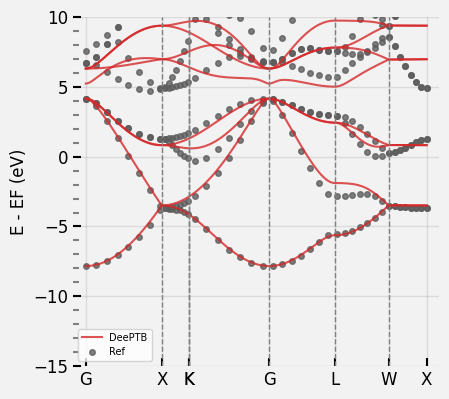

In [5]:
from dptb.postprocess.bandstructure.band import Band
from dptb.nn.nnsk import NNSK
from dptb.utils.tools import j_loader

# 为了演示，我们提供了存档文件位于 ref_ckpts/nnsk，也可用于绘图
model = NNSK.from_reference(checkpoint="./nnsk/checkpoint/nnsk.iter500.pth",
                            basis={'Si': ['3s', '3p']})
jdata = j_loader("./run/band.json") # 这里提供输入
results_path = "./band_plot"        # 可指定输出的保存路径
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "pbc": True}

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

**小结**: 可以看出该模型已经具有能带的大致形状。要注意的是这里我们只是采用了 3s，3p 轨道，只考虑**第一近邻**。如果我们后续只需要价带的信息，那么**无需增加轨道**，只需要修改训练的能带窗口和调整权重，并可以通过增加近邻的方式得到一个更准确的价带的 TB 模型。

可是往往我们需要导带的信息，这时候我们需要引入更多的轨道，**DeePTB** 支持用户自由地在训练过程中增减轨道和近邻。我们下一步进行增加轨道和近邻的训练。

####  **2.2 增加轨道和近邻**

#####  **2.2.1 增加轨道**

通过修改输入文件，我们在这里加入辅助极化轨道 `d*`，使模型能够拟合考虑的导带。这对于一些需要导带的性质的计算，例如光电性质，和电子的输运性质至关重要。极化轨道的加入可以直接按照下面的写法：
```json
"basis": {
    "Si": ["3s", "3p", "d*"]
    }
```

另外，在进行第一步的时候，我们对于 onsite 的计算没有加修正。我们这里使用 strian 方法，令 `NNSK` 模型能够更新 onsite 矩阵。具体的输入为：

```json
        "nnsk": {
            "onsite": {"method": "strain", "rs":2.5 ,"w":0.3},
            "hopping": {"method": "powerlaw", "rs":2.6, "w": 0.3}
        }
```


这里"method": "strain" 表示开启 strian mode 的 onsite matrix 修正。strain 方法同样需要提供 `rs` 参数，用来表明在 strian 模型下，onsite matrix 只考虑 onsite_cutoff 以内的原子的贡献。对于onsite，通常选取第一近邻即可。

接着，我们通过 `-i[init-model]` 参数加载上一步训练的模型，运行：

In [6]:
!dptb train ./inputs/2-2-1_input.json -i ./nnsk/checkpoint/nnsk.iter500.pth -o ./nnsk_2

DEEPTB INFO    Initializing Orbital ['3s', '3p', 'd*'] of Atom Si from ['3s', '3p']
DEEPTB INFO    Epoch 1 summary:	train_loss: 0.588598	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep1
DEEPTB INFO    Epoch 2 summary:	train_loss: 0.579519	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep2
DEEPTB INFO    Epoch 3 summary:	train_loss: 0.575074	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep3
DEEPTB INFO    Epoch 4 summary:	train_loss: 0.576551	
#####################################################################################

训练收敛后查看能带拟合结果

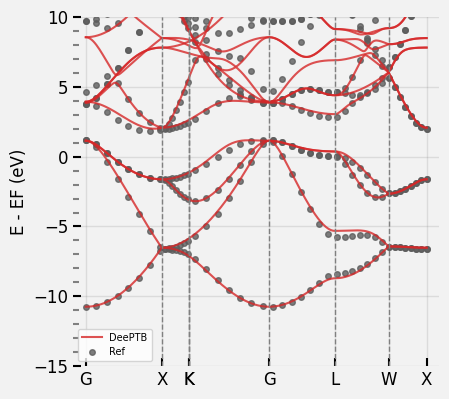

In [7]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_2/checkpoint
model = NNSK.from_reference(checkpoint="./nnsk_2/checkpoint/nnsk.ep500.pth",
                            basis={'Si': ['3s', '3p', 'd*']})

jdata = j_loader("./run/band.json") 
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 2.6, "oer_max": 2.5, "pbc": True}

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

**Note**: 实际使用中，我们发现用最小基组作为初始训练，并逐渐增加基组的策略，比直接用完整的轨道初始化从头训练更好。这同时可以帮助我们减小使用的基组数，并提升训练的稳定性。

从上面的结果可以看到，此时能带拟合结果已经相当准确。

#####  **2.2.2 增加近邻**

为了进一步提高精度，我可以通过增加近邻键长 `r_max` 来考虑更远的近邻的紧束缚模型。

增加近邻包含两步操作：
1. 在`info.json`中调整 `r_max`，增加数值到如 5.0 （包含第三近邻，但不包含第四近邻）。
2. 由于原子的离散分布，如果直接突然从最近邻直接加入第二近邻、第三近邻引将引起突变，对哈密顿量的变化太大，会导致之前的拟合结果失效。因此，需要采用一个平滑的阶段函数来对键长的增加进行过渡，通过缓慢地把截断函数向更远的截断推进，从而实现渐进地增加近邻。

截断函数的采取的形式是：
$$f_s(r)=\frac{1}{1+e^{(r-r_{skc})/w}}$$

通过调整参数，我们可以得到一个平滑的过渡。衰减函数在输入文件可设置的参数为：
  - `rs`（Angstrom）：即 $r_{skc}$，控制衰减函数的截断位置；
  - `w`：表示衰减函数的平缓程度。

衰减函数的控制如图所示：

<img src="http://dp-filetrans.oss-accelerate.aliyuncs.com/DeePTB/fs.png?OSSAccessKeyId=LTAI5tRnCpedMnKSH3APDceY&Expires=1001689817842&Signature=vPCZISacus8CuXXsvCWkpU07vQc%3D" alt="Fig2" style="zoom: 40%;">

正如上图所示，这个平滑函数将以 $r_{skc}$ 为中心衰减。这个函数根据 w 的形式，具有不同的平滑性。为了在保持拟合稳定性的同时考虑更多邻居项，我们首先将 $r_{skc}$ 设定为第一最近邻距离，这样的衰减函数可以抑制新包含的第二和第三邻居项，不会对预测的哈密顿带来突然的变化。

我们可以将 $r_{skc}$ 从起始第一近邻慢慢外推到新的 `r_max` （包含三近邻）。

输入文件中，通过 `push` 关键词中设置 `rs_ths` 和 `period`，即可按照上述公式中的 $r_{skc}$ 从第一近邻缓慢外推至第三近邻。在外推时，每间隔 `period` 个 epoch 就按 `rs_thr` 中设置的每步步长更新 $r_{skc}$。

**注意** 如果 `rs_thr` 设置得太大，那么外推的过程就不能称之为缓变，仍然可能会导致模型训练的不收敛。

具体输入文件可参考 `inputs/2-2-2-1_input.json`。

In [8]:
!dptb train ./inputs/2-2-2_1_input.json -i ./nnsk_2/checkpoint/nnsk.ep500.pth -o ./nnsk_3

DEEPTB INFO    Epoch 1 summary:	train_loss: 0.015382	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep1
DEEPTB INFO    Epoch 2 summary:	train_loss: 0.020359	
################################################################################################################################################################
DEEPTB INFO    Epoch 3 summary:	train_loss: 0.015663	
################################################################################################################################################################
DEEPTB INFO    Epoch 4 summary:	train_loss: 0.017501	
################################################################################################################################################################
DEEPTB INFO    Epoch 5 summary:	train_loss: 0.018411	
##########################################

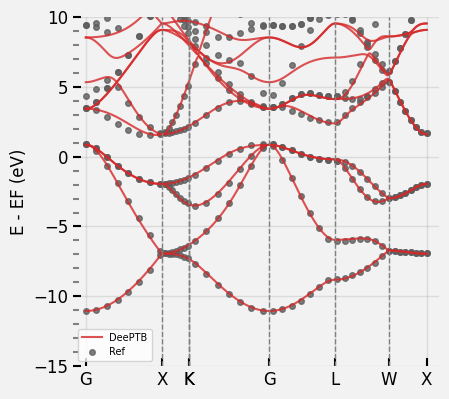

In [9]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_3/checkpoint
model = NNSK.from_reference(checkpoint="./nnsk_3/checkpoint/nnsk.iter_rs4.832_w0.300.pth",
                            basis={'Si': ['3s', '3p', 'd*']})

jdata = j_loader("./run/band.json") # 这里提供输入
results_path = "./band_plot"        # 可指定输出的保存路径
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max": 2.5, "pbc": True}

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

类似地，我们也可以将 $w$ 逐渐变得更小，这样衰减函数引入的衰减将会更快。这一步衰减的目的主要是是在外推 $r_{skc}$ 之后，限制更远的近邻不会进入考虑。
此时修改的输入参数为：
具体输入文件参考 `inputs/2-2-2-2_input.json`。

In [15]:
!dptb train ./inputs/2-2-2_2_input.json -i ./nnsk_3/checkpoint/nnsk.iter_rs4.832_w0.300.pth -o ./nnsk_4

DEEPTB INFO    Epoch 1 summary:	train_loss: 0.009051	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep1
DEEPTB INFO    Epoch 2 summary:	train_loss: 0.198875	
################################################################################################################################################################
DEEPTB INFO    Epoch 3 summary:	train_loss: 0.019598	
################################################################################################################################################################
DEEPTB INFO    Epoch 4 summary:	train_loss: 0.075552	
################################################################################################################################################################
DEEPTB INFO    Epoch 5 summary:	train_loss: 0.118910	
##########################################

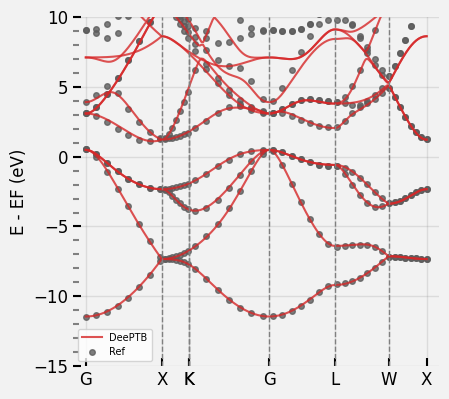

In [16]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_4/checkpoint
model = NNSK.from_reference(checkpoint="./nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.097.pth",
                            basis={'Si': ['3s', '3p', 'd*']})

jdata = j_loader("./run/band.json")
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max": 2.5, "pbc": True}

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

####  **2.3 训练MD数据 (键长变化的依赖)**
在 **DeePTB** 中，基于物理图像建模的 SK 积分由各种键长相关函数参数化，例如上面的 `power-law` 形式中键积分就是键长的显函数。这为 `NNSK` 模型提供了良好的转移性，可以充分地模拟结构畸变对电子结构引起的的变化。

为了进一步的提高这样的迁移能力，我们强烈建议进行键长依赖性参数的训练。这样的训练可以通过 MD 轨迹的数据集轻松获得。

我们提供了 25K，100K 和 300K 下的 10 个 MD 帧的数据集。用户可以对应地通过修改输入配置中的 `data_options/train/prefix` 为 `kpathmd25/kpathmd100/kpathmd300`，并在训练时使用 `-i` 初始化检查点训练模型，就可以轻松获得键长依赖的 `NNSK` 模型。
> 这里的能带数据中k点的选取比较密，会降低一定的计算速度。用户可以自行选取部分k点，例如隔3个选取一个点进行训练。

在 MD 轨迹数据集的训练中，输入文件的`data_options`数据输入模块除了提供 MD 轨迹数据的`train`数据集以外，还建议提供先前训练所用的单结构数据集作为`reference`数据集。这样可以使得 MD 轨迹的训练更加稳定。使用`reference`数据集还需要在`train_option`中指定`ref_batch_size`以及在`train_loss`中指定对应的`reference`数据集loss计算方法，其余的输入内容均不变。具体的输入内容可以参考`./inputs/2-3_1_input.json`。

训练得到模型后，用户可以使用上文同样的能带绘制 API 绘制能带结构，绘图相关参数在 `./run/band_2.json` 中。

In [18]:
!dptb train ./inputs/2-3_1_input.json -i ./nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.097.pth -o ./nnsk_md25

DEEPTB INFO    iteration:10	train_loss: 0.044349  (0.061853)	lr: 0.01
DEEPTB INFO    Epoch 1 summary:	train_loss: 0.087748	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep1
DEEPTB INFO    iteration:20	train_loss: 0.039037  (0.037905)	lr: 0.00999
DEEPTB INFO    Epoch 2 summary:	train_loss: 0.040000	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep2
DEEPTB INFO    iteration:30	train_loss: 0.032674  (0.035480)	lr: 0.00998
DEEPTB INFO    Epoch 3 summary:	train_loss: 0.037720	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as nnsk.ep3
DEEPTB 

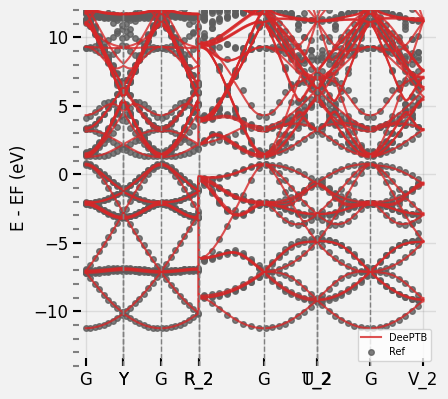

In [20]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_md25/checkpoint
model = NNSK.from_reference(checkpoint="./ref_ckpts/nnsk_md25/checkpoint/nnsk.ep499.pth",
                            basis={'Si': ['3s', '3p', 'd*']})

jdata = j_loader("./run/band_2.json")
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/kpathmd25.0/struct.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max": 2.5, "pbc": True}

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

在一个温度的MD轨迹下训练得到的模型可以直接加载到另一个温度的MD轨迹下进行进一步的键长变化依赖训练：

In [22]:
!dptb train ./inputs/2-3_2_input.json -i ./ref_ckpts/nnsk_md25/checkpoint/nnsk.ep499.pth -o ./nnsk_md100

Processing dataset...
Loading data:   0%|                                       | 0/1 [00:00<?, ?it/s]/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/dptb/data/dataset/_default_dataset.py:219: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  atomic_data[AtomicDataDict.KPOINT_KEY] = torch.as_tensor(self.data["kpoints"][frame][:],
Loading data: 100%|███████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]
DEEPTB INFO    Loaded data: Batch(atomic_numbers=[80, 1], batch=[80], bwindow=[10, 2], cell=[10, 3, 3], edge_cell_shift=[2240, 3], edge_features=[2240, 1], edge_index=[2, 2240], edge_overlap=[2240, 1], eigenvalue=

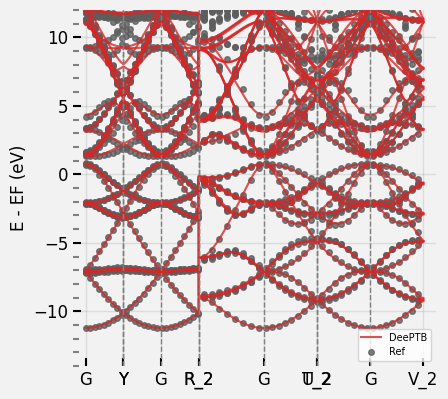

In [23]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_md100/checkpoint
model = NNSK.from_reference(checkpoint="./nnsk_md100/checkpoint/nnsk.ep22.pth",
                            basis={'Si': ['3s', '3p', 'd*']}) 

jdata = j_loader("./run/band_2.json")
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/kpathmd25.0/struct.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max": 2.5, "pbc": True}

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

####  **2.4 训练环境修正：dptb 模型**

**DeePTB** 提供了具有对称保持神经网络的强大的环境依赖建模。基于前面构建的 `nnsk` 模型，我们可以通过加入环境依赖的部分进一步增强TB模型的描述能力，以克服由两中心近似带来的精度限制。在 `nnsk` 模型基础上，加入环境依赖性的模型称为`dptb`模型，其能量表达式如下：
$$
\begin{equation}
h^{\text{env}}_{ll^\prime{\zeta}} =  h_{ll^\prime{\zeta}}(r_{ij}) \times \left[1+\Phi_{ll^\prime\zeta}^{o_i,o_j}\left(r_{ij},\mathcal{D}^{ij}\right)\right]	
\end{equation}
$$
其中，$\mathcal{D}^{ij}$ 是环境描述符，通过 `embedding` 关键词定义；而 $\Phi_{ll^\prime\zeta}^{o_i,o_j}$ 则是提供环境修正预测值的神经网络。

定义`dptb`模型，需要在训练输入文件的`model_options`提供下面的关键词：
- `embedding`：其中的`method`指定在`dptb`模型中使用的原子环境的描述符形式，在本例中我们使用类似 **DeePMD** 中使用的 `se2` 形式描述符，描述符形式可以参见[DeePTB paper](https://arxiv.org/abs/2307.04638)；
- `prediction`：用`method`指定模型的预测方法，这里指定为`sktb`，其中`neurons`指定了预测网络的大小；
- `nnsk`：与`nnsk`模型中的内容一致。其中，`freeze`选项应设置为`true`，表示固定`nnsk`模型训练好的sk参数，只训练环境依赖部分的神经网络参数。这部分的固定很重要，否则在`dptb`第一步初始化就有可能完全破坏`nnsk`的参数，导致训练不收敛。

输入的完整内容可以参看`./inputs/2-4_input.json`。环境依赖的`dptb`模型训练需要读取`nnsk`的模型。我们可以运行：

In [26]:
!dptb train ./inputs/2-4_input.json -i ./ref_ckpts/nnsk_md100/checkpoint/nnsk.ep500.pth -o ./dptb

DEEPTB WARNING The push option is not supported in the mixed model. The push option is only supported in the nnsk model.
DEEPTB INFO    The ['hopping_param', 'strain_param'] are frozed!
DEEPTB INFO    Epoch 1 summary:	train_loss: 0.023215	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as mix.ep1
DEEPTB INFO    Epoch 2 summary:	train_loss: 0.022016	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as mix.ep2
DEEPTB INFO    Epoch 3 summary:	train_loss: 0.021845	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as mix.ep3
DEEPTB INFO    Epoch 4 summary:	train_lo

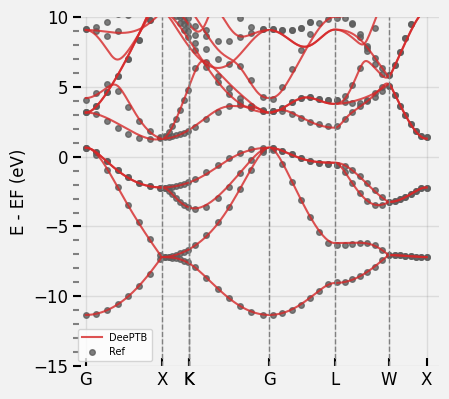

In [27]:
# 绘制dptb拟合的能带需要加载 MIX 模型
from dptb.nn.deeptb import MIX

# 演示结果用的存档模型位于 ref_ckpts/dptb/checkpoint
# 此处加载模型的设定json文件同样提供在ref_ckpts/dptb
jdata_model = j_loader("./dptb/train_config.json")
model = MIX.from_reference(checkpoint="./dptb/checkpoint/mix.best.pth",
                           **jdata_model["common_options"],
                           **jdata_model["model_options"])

jdata_run = j_loader("./run/band.json")
results_path = "./band_plot"
kpath_kwargs = jdata_run["task_options"]
stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "er_max":5.0, "oer_max": 2.5, "pbc": True}

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])